## TP 2
## Implementación Algoritmo Frequency Domain Image Blur Measure (FM)

In [71]:
# Importamos las librerias necesarias
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [73]:
def image_quality_measure(frame):
    th_counter = 0
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    
    # Cambiamos el frame a escala de grises solo para realizar los calculos
    frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Obtenemos la transformada de Fourier del frame
    frame_f = np.fft.fft2(frame_grey)
    
    # Obtenemos Fc reacomodando la transformada de Fourier al origen
    fc = np.fft.fftshift(frame_f)

    # Obtenemos el modulo
    abs_fc = np.abs(fc)

    # Obtenemos el valor maximo
    frame_M = np.amax(abs_fc)

    # Calculamos el threshold
    frame_thres = frame_M / 1000

    # Calculamos Th
    for element in np.nditer(abs_fc):
        if element > frame_thres:
            th_counter += 1

    # Calculamos el IQM (FM)
    iqm = th_counter / (frame_height*frame_width)

    return iqm

In [100]:
def get_roi_borders(frame_width, frame_height, roi=None, focus_matrix_size=None, grid_side=None):

    if roi:
        width_factor = frame_width * roi
        height_factor = frame_height * roi
    else:
        width_factor = focus_matrix_size[0] * grid_side + (focus_matrix_size[0] - 1) * grid_side
        height_factor = focus_matrix_size[1] * grid_side + (focus_matrix_size[1] - 1) * grid_side


    x_start = (frame_width - width_factor) // 2
    y_start = (frame_height - height_factor) // 2

    x_end = (x_start + width_factor)
    y_end = (y_start + height_factor)

    return int(x_start), int(x_end), int(y_start), int(y_end)

In [142]:
def unsharp_masking(frame, sigma=1.0, definition=5.5, debug=False):
    """
    Aplica unsharp masking a un frame.

    Parámetros:
    frame (numpy.ndarray): La imagen de entrada.
    sigma (float): Desviación estándar para el filtro gaussiano.
    definition (float): Factor que se le aplicará las máscaras (alpha y -beta en addWeighted).

    Retorno:
    numpy.ndarray: La imagen con unsharp masking aplicado.
    """
    
    # Se aplica un filtro gaussiano para suavizar la imagen
    blurred_frame = cv2.GaussianBlur(frame, (0, 0), sigma)
    
    # Se crea imagen final restando la imagen suavizada a la imagen original
    img_unsharp = cv2.addWeighted(frame, 1.0 + definition, blurred_frame, -definition, 0)
    
    return img_unsharp


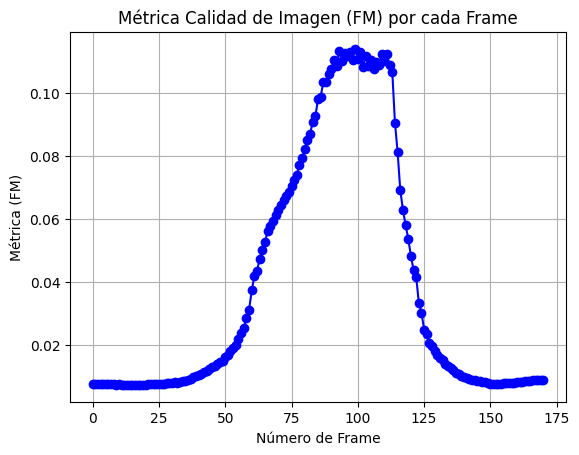

In [174]:
# Experimento 1 - Frame completo

# Abrimos el video
video_path = "./focus_video.mov"
capture_video = cv2.VideoCapture(video_path)
output_video_exp1 = "./experimento1_frame_completo.mov"
unsharp_mask_exp1 = True
iqm_metrics_exp1 = []
frame_number_exp1 = []

if not capture_video.isOpened():
    print("Error al abrir el video")

# Obtenemos la metadata del video
frame_fps = capture_video.get(cv2.CAP_PROP_FPS)
frame_count = int(capture_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(capture_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(capture_video.get(cv2.CAP_PROP_FRAME_WIDTH))

roi = 1
threshold_exp1 = 0.02
focus_matrix = False

# Determinamos el area del ROI, en este caso ROI = Frame Completo
x_start, x_end, y_start, y_end = get_roi_borders(frame_width, frame_height, roi)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_video_exp1, fourcc, frame_fps, (frame_width, frame_height))

while capture_video.isOpened():
    frame_number = capture_video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = capture_video.read()
    if not ret:
        break
    
    # Aplicamos funcionalidad de "Unsharp Masking" a cada frame
    frame = unsharp_masking(frame) if unsharp_mask_exp1 else frame
    
    roi_area = frame[y_start:y_end, x_start:x_end]
    iqm = image_quality_measure(roi_area)
    iqm_metrics_exp1.append(iqm)
    frame_number_exp1.append(frame_number)

    # Se muestra la mediana de la métrica en el video
    cv2.putText(frame, f"Metrica FM: {iqm}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Se muestra el rectangulo que indica el ROI
    rectangle_color = (0, 255, 0) if iqm > threshold_exp1 else (0, 0, 255)

    # Se dibuja el rectangulo indicando el ROI
    cv2.rectangle(frame, (x_start, y_end), (x_end, y_start), rectangle_color, 4)
    
    # Se muestra el frame con los datos estampados
    cv2.imshow('Video con matriz de enfoque', frame)

    output.write(frame)
        
# Se grafica número de frame vs medida de la métrica
plt.figure()
plt.plot(frame_number_exp1, iqm_metrics_exp1, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Frame')
plt.ylabel('Métrica (FM)')
plt.title('Métrica Calidad de Imagen (FM) por cada Frame')
plt.grid(True)
plt.show()

capture_video.release()
output.release()
cv2.destroyAllWindows()

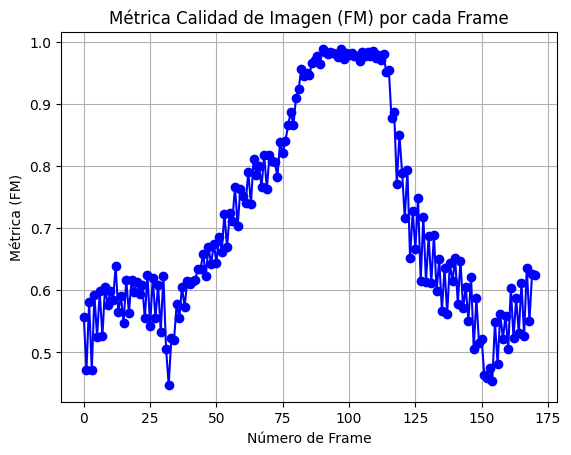

In [175]:
# Experimento 2 - ROI = 10%

# Abrimos el video
video_path = "./focus_video.mov"
capture_video = cv2.VideoCapture(video_path)
output_video_exp2 = "./experimento2_roi010.mov"
unsharp_mask_exp2 = True
iqm_metrics_exp2 = []
frame_number_exp2 = []

if not capture_video.isOpened():
    print("Error al abrir el video")

# Obtenemos la metadata del video
frame_fps = capture_video.get(cv2.CAP_PROP_FPS)
frame_count = int(capture_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(capture_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(capture_video.get(cv2.CAP_PROP_FRAME_WIDTH))

roi = 0.1
threshold_exp2 = 0.80
focus_matrix = False

# Determinamos el area del ROI, en este caso ROI = Frame Completo
x_start, x_end, y_start, y_end = get_roi_borders(frame_width, frame_height, roi)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_video_exp2, fourcc, frame_fps, (frame_width, frame_height))

while capture_video.isOpened():
    frame_number = capture_video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = capture_video.read()
    if not ret:
        break

    # Aplicamos funcionalidad de "Unsharp Masking" a cada frame
    frame = unsharp_masking(frame) if unsharp_mask_exp2 else frame
    
    roi_area = frame[y_start:y_end, x_start:x_end]
    iqm = image_quality_measure(roi_area)
    iqm_metrics_exp2.append(iqm)
    frame_number_exp2.append(frame_number)

    # Se muestra la mediana de la métrica en el video
    cv2.putText(frame, f"Metrica FM: {iqm}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Se muestra el rectangulo que indica el ROI
    rectangle_color = (0, 255, 0) if iqm > threshold_exp2 else (0, 0, 255)

    # Se dibuja el rectangulo indicando el ROI
    cv2.rectangle(frame, (x_start, y_end), (x_end, y_start), rectangle_color, 2)
    
    # Se muestra el frame con los datos estampados
    cv2.imshow('Video con matriz de enfoque', frame)

    output.write(frame)
        
# Se grafica número de frame vs medida de la métrica
plt.figure()
plt.plot(frame_number_exp2, iqm_metrics_exp2, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Frame')
plt.ylabel('Métrica (FM)')
plt.title('Métrica Calidad de Imagen (FM) por cada Frame')
plt.grid(True)
plt.show()

capture_video.release()
output.release()
cv2.destroyAllWindows()

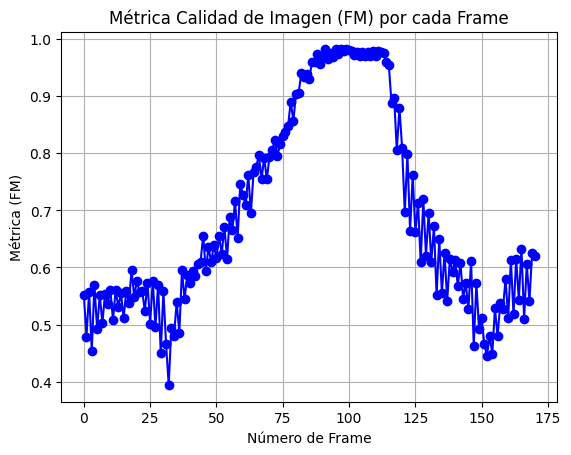

In [170]:
# Experimento 3a - Matriz de Enfoque 3x3

# Abrimos el video
video_path = "./focus_video.mov"
capture_video = cv2.VideoCapture(video_path)
output_video_exp3a = "./experimento3_matrix_3x3.mov"
threshold_exp3a = 0.90
unsharp_mask_exp3a = True
iqm_metrics_exp3a = []
frame_number_exp3a = []

if not capture_video.isOpened():
    print("Error al abrir el video")

# Obtenemos la metadata del video
frame_fps = capture_video.get(cv2.CAP_PROP_FPS)
frame_count = int(capture_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(capture_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(capture_video.get(cv2.CAP_PROP_FRAME_WIDTH))

grid_side = 10
focus_matrix = True
focus_matrix_size = (3, 3)

# Calculamos el tamaño de la matriz
x_start, x_end, y_start, y_end = get_roi_borders(frame_width, frame_height, focus_matrix_size=focus_matrix_size, grid_side=grid_side)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_video_exp3a, fourcc, frame_fps, (frame_width, frame_height))

while capture_video.isOpened():
    frame_number = capture_video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = capture_video.read()
    if not ret:
        break

    # Aplicamos funcionalidad de "Unsharp Masking" a cada frame
    frame = unsharp_masking(frame) if unsharp_mask_exp3a else frame
    
    roi_area = frame[y_start:y_end, x_start:x_end]
    iqm = image_quality_measure(roi_area)
    iqm_metrics_exp3a.append(iqm)
    frame_number_exp3a.append(frame_number)
    
    for i in range(focus_matrix_size[0]):
        for j in range(focus_matrix_size[1]):
            grid_x_start = x_start + j * (2*grid_side)
            grid_y_start = y_start + i * (2*grid_side)
            grid_x_end = grid_x_start + grid_side
            grid_y_end = grid_y_start + grid_side

            rectangle_color = (0, 255, 0) if iqm > threshold_exp3a else (0, 0, 255)
            cv2.rectangle(frame, (grid_x_start, grid_y_start), (grid_x_end, grid_y_end), rectangle_color, 2)

    output.write(frame)

# Se grafica número de frame vs medida de la métrica
plt.figure()
plt.plot(frame_number_exp3a, iqm_metrics_exp3a, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Frame')
plt.ylabel('Métrica (FM)')
plt.title('Métrica Calidad de Imagen (FM) por cada Frame')
plt.grid(True)
plt.show()

capture_video.release()
output.release()
cv2.destroyAllWindows()
        

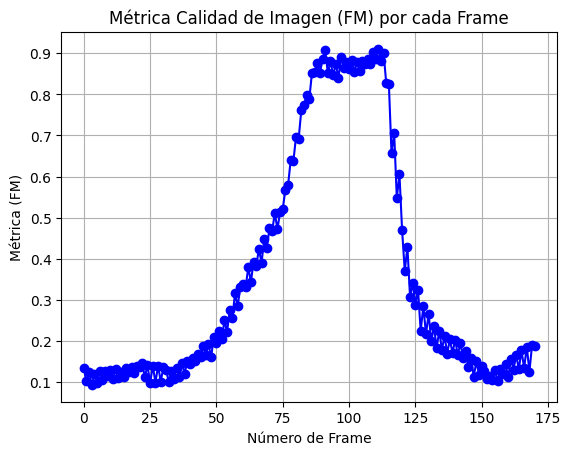

In [171]:
# Experimento 3b - Matriz de enfoque 7x7

# Abrimos el video
video_path = "./focus_video.mov"
capture_video = cv2.VideoCapture(video_path)
output_video_exp3b = "./experimento3_matrix_7x7.mov"
threshold_exp3b = 0.60
unsharp_mask_exp3b = True
iqm_metrics_exp3b = []
frame_number_exp3b = []

if not capture_video.isOpened():
    print("Error al abrir el video")

# Obtenemos la metadata del video
frame_fps = capture_video.get(cv2.CAP_PROP_FPS)
frame_count = int(capture_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(capture_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(capture_video.get(cv2.CAP_PROP_FRAME_WIDTH))

grid_side = 10
focus_matrix = True
focus_matrix_size = (7, 7)

# Calculamos el tamaño de la matriz
x_start, x_end, y_start, y_end = get_roi_borders(frame_width, frame_height, focus_matrix_size=focus_matrix_size, grid_side=grid_side)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_video_exp3b, fourcc, frame_fps, (frame_width, frame_height))

while capture_video.isOpened():
    frame_number = capture_video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = capture_video.read()
    if not ret:
        break

    # Aplicamos funcionalidad de "Unsharp Masking" a cada frame
    frame = unsharp_masking(frame) if unsharp_mask_exp3b else frame
    
    roi_area = frame[y_start:y_end, x_start:x_end]
    iqm = image_quality_measure(roi_area)
    iqm_metrics_exp3b.append(iqm)
    frame_number_exp3b.append(frame_number)
    
    for i in range(focus_matrix_size[0]):
        for j in range(focus_matrix_size[1]):
            grid_x_start = x_start + j * (2*grid_side)
            grid_y_start = y_start + i * (2*grid_side)
            grid_x_end = grid_x_start + grid_side
            grid_y_end = grid_y_start + grid_side

            
            rectangle_color = (0, 255, 0) if iqm > threshold_exp3b else (0, 0, 255)
            cv2.rectangle(frame, (grid_x_start, grid_y_start), (grid_x_end, grid_y_end), rectangle_color, 2)

    output.write(frame)

# Se grafica número de frame vs medida de la métrica
plt.figure()
plt.plot(frame_number_exp3b, iqm_metrics_exp3b, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Frame')
plt.ylabel('Métrica (FM)')
plt.title('Métrica Calidad de Imagen (FM) por cada Frame')
plt.grid(True)
plt.show()

capture_video.release()
output.release()
cv2.destroyAllWindows()

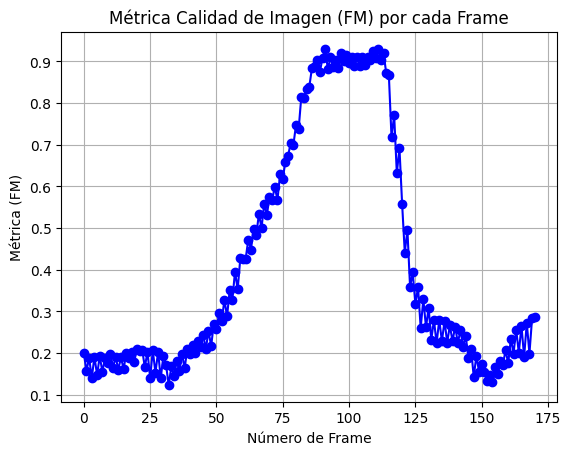

In [172]:
# Experimento 3c - Matriz de enfoque 5x7

# Abrimos el video
video_path = "./focus_video.mov"
capture_video = cv2.VideoCapture(video_path)
output_video_exp3c = "./experimento3_matrix_5x7.mov"
threshold_exp3c = 0.60
unsharp_mask_exp3c = True
iqm_metrics_exp3c = []
frame_number_exp3c = []

if not capture_video.isOpened():
    print("Error al abrir el video")

# Obtenemos la metadata del video
frame_fps = capture_video.get(cv2.CAP_PROP_FPS)
frame_count = int(capture_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(capture_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(capture_video.get(cv2.CAP_PROP_FRAME_WIDTH))

grid_side = 10
focus_matrix = True
focus_matrix_size = (5, 7)

# Calculamos el tamaño de la matriz
x_start, x_end, y_start, y_end = get_roi_borders(frame_width, frame_height, focus_matrix_size=focus_matrix_size, grid_side=grid_side)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_video_exp3c, fourcc, frame_fps, (frame_width, frame_height))

while capture_video.isOpened():
    frame_number = capture_video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = capture_video.read()
    if not ret:
        break

    # Aplicamos funcionalidad de "Unsharp Masking" a cada frame
    frame = unsharp_masking(frame) if unsharp_mask_exp3c else frame
    
    roi_area = frame[y_start:y_end, x_start:x_end]
    iqm = image_quality_measure(roi_area)
    iqm_metrics_exp3c.append(iqm)
    frame_number_exp3c.append(frame_number)
    
    for i in range(focus_matrix_size[0]):
        for j in range(focus_matrix_size[1]):
            grid_x_start = x_start + j * (2*grid_side)
            grid_y_start = y_start + i * (2*grid_side)
            grid_x_end = grid_x_start + grid_side
            grid_y_end = grid_y_start + grid_side

            
            rectangle_color = (0, 255, 0) if iqm > threshold_exp3c else (0, 0, 255)
            cv2.rectangle(frame, (grid_x_start, grid_y_start), (grid_x_end, grid_y_end), rectangle_color, 2)

    output.write(frame)

# Se grafica número de frame vs medida de la métrica
plt.figure()
plt.plot(frame_number_exp3c, iqm_metrics_exp3c, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Frame')
plt.ylabel('Métrica (FM)')
plt.title('Métrica Calidad de Imagen (FM) por cada Frame')
plt.grid(True)
plt.show()

capture_video.release()
output.release()
cv2.destroyAllWindows()

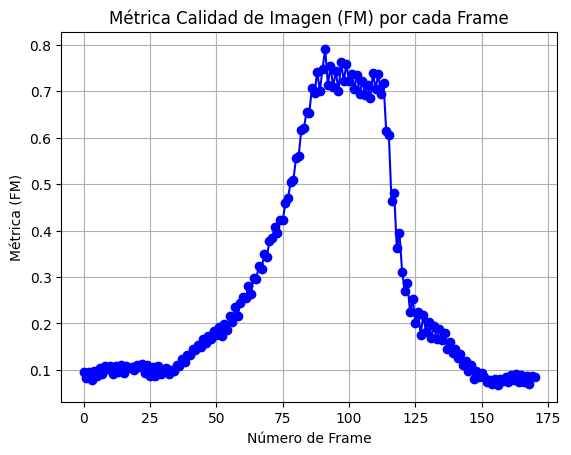

In [173]:
# Experimento 3d - Matriz de enfoque 10x10

# Abrimos el video
video_path = "./focus_video.mov"
capture_video = cv2.VideoCapture(video_path)
output_video_exp3d = "./experimento3_matrix_10x10.mov"
threshold_exp3d = 0.60
unsharp_mask_exp3d = True
iqm_metrics_exp3d = []
frame_number_exp3d = []

if not capture_video.isOpened():
    print("Error al abrir el video")

# Obtenemos la metadata del video
frame_fps = capture_video.get(cv2.CAP_PROP_FPS)
frame_count = int(capture_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(capture_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(capture_video.get(cv2.CAP_PROP_FRAME_WIDTH))

grid_side = 10
focus_matrix = True
focus_matrix_size = (10, 10)

# Calculamos el tamaño de la matriz
x_start, x_end, y_start, y_end = get_roi_borders(frame_width, frame_height, focus_matrix_size=focus_matrix_size, grid_side=grid_side)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_video_exp3d, fourcc, frame_fps, (frame_width, frame_height))

while capture_video.isOpened():
    frame_number = capture_video.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = capture_video.read()
    if not ret:
        break

    # Aplicamos funcionalidad de "Unsharp Masking" a cada frame
    frame = unsharp_masking(frame) if unsharp_mask_exp3d else frame
    
    roi_area = frame[y_start:y_end, x_start:x_end]
    iqm = image_quality_measure(roi_area)
    iqm_metrics_exp3d.append(iqm)
    frame_number_exp3d.append(frame_number)
    
    for i in range(focus_matrix_size[0]):
        for j in range(focus_matrix_size[1]):
            grid_x_start = x_start + j * (2*grid_side)
            grid_y_start = y_start + i * (2*grid_side)
            grid_x_end = grid_x_start + grid_side
            grid_y_end = grid_y_start + grid_side

            
            rectangle_color = (0, 255, 0) if iqm > threshold_exp3d else (0, 0, 255)
            cv2.rectangle(frame, (grid_x_start, grid_y_start), (grid_x_end, grid_y_end), rectangle_color, 2)

    output.write(frame)

# Se grafica número de frame vs medida de la métrica
plt.figure()
plt.plot(frame_number_exp3d, iqm_metrics_exp3d, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Frame')
plt.ylabel('Métrica (FM)')
plt.title('Métrica Calidad de Imagen (FM) por cada Frame')
plt.grid(True)
plt.show()

capture_video.release()
output.release()
cv2.destroyAllWindows()